In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import json
import os
import requests
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

ANGLE_W = 3.15
SPEED_W = 3.75


In [2]:
# Return df with added movement, angle and time change data for each hand
# Each row is relative to the previous note on that hand
def hand_stats(notes: pd.DataFrame):
    # Calculate note centers
    notes['_yCenter'] = 1 + notes['_lineLayer'] * 0.55
    notes['_xCenter'] = -0.9 + notes['_lineIndex'] * 0.6

    # Split to left and right handed notes
    left = notes[notes['_type'] == 0].copy()
    right = notes[notes['_type'] == 1].copy()

    # Calculate position and angle changes between notes
    # Each row contains the change between the previous note and itself
    for df in [left, right]:
        df['_xMovement'] = df['_xCenter'].diff()
        df['_yMovement'] = df['_yCenter'].diff()
        df['_totMovement'] = np.hypot(df['_xMovement'], df['_yMovement'])
        df['_angleChange'] = np.arctan(df['_yMovement'] / df['_xMovement'])
        df['_timeChange'] = df['_time'].diff()
        df.iloc[0] = df.iloc[0].fillna(0) # Set movements and changes to 0 in first row

    # Recombine dfs now that we've calculated the hand specific stats
    notes = pd.concat([left, right]).sort_index()

    return notes

In [3]:
def calculate_features(notes: pd.DataFrame, mapset_info):
    # Convert note timings from beats to seconds
    notes['_time'] = notes['_time'] * (1 / mapset_info['_beatsPerMinute']) * 60

    # Add hand stats
    notes = hand_stats(notes)

    # Calculate overall angle and swing speed stats
    average_angle = notes['_angleChange'].abs().mean()
    sum_of_swing_times = notes[notes['_timeChange'] < 5]['_timeChange'].sum()
    total_distance = notes[notes['_totMovement'] > 0.54]['_totMovement'].sum()
    average_speed = total_distance / sum_of_swing_times

    return average_angle, average_speed

In [4]:
# Get hash, diff and complexity from AccSaber
r = requests.get('https://api.accsaber.com/ranked-maps')
accsaber_ranked = pd.read_json(r.text)
accsaber_ranked.drop(['songSubName', 'songAuthorName', 'levelAuthorName', 'categoryDisplayName', 'dateRanked'], axis=1, inplace=True)
accsaber_ranked['difficulty'] = accsaber_ranked['difficulty'].map(lambda diff: diff[0].upper() + diff[1:]) # Fix inconsistent capitalising
accsaber_ranked['songHash'] = accsaber_ranked['songHash'].map(lambda hash: hash.lower()) # Fix inconsistent capitalising

/var/folders/hx/8pb__z8x49q872rhs7wcd7_m0000gn/T/ipykernel_3458/1366010025.py:3: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  accsaber_ranked = pd.read_json(r.text)


In [5]:
root = './accsaber-maps'


# Run algo on maps
for entry in tqdm(os.scandir(root)):
    if not os.path.isdir(entry):
        continue
    
    files = [f for f in os.listdir(entry) if os.path.isfile(os.path.join(entry, f))]
    info_path = ''
    if 'Info.dat' in files:
        info_path = os.path.join(entry, 'Info.dat')
    elif 'info.dat' in files:
        info_path = os.path.join(entry, 'info.dat')
    else:
        continue
    
    with open(info_path, encoding='utf8') as json_data:
        mapset_info = json.load(json_data)

    standard_characterisitic = next((x for x in mapset_info['_difficultyBeatmapSets'] if x['_beatmapCharacteristicName'] == 'Standard'))
    for diff in standard_characterisitic['_difficultyBeatmaps']:
        diff_file_name = diff['_beatmapFilename']
        if diff_file_name in files: # Assumes only ranked diffs are in the directory
            diff_path = os.path.join(entry, diff_file_name)
            with open(diff_path) as json_data:
                diff_data = json.load(json_data)
            try:
                notes = pd.DataFrame(diff_data['_notes'])
            except:
                continue
            average_angle, average_speed = calculate_features(notes, mapset_info)

            # Add to df
            idx = accsaber_ranked.index[(accsaber_ranked['songHash'] == mapset_info['_hash']) & (accsaber_ranked['difficulty'] == diff["_difficulty"])]
            if len(idx) != 1:
                print('Error identifying map.')
            idx = idx[0]
            accsaber_ranked.loc[idx, 'averageAngle'] = average_angle
            accsaber_ranked.loc[idx, 'averageSpeed'] = average_speed

211it [00:02, 93.90it/s] 


In [6]:
# Drop maps that weren't calculated (v3, map couldn't be downloaded, etc)
accsaber_ranked = accsaber_ranked.dropna()

In [7]:
results = []
for aw in tqdm(np.arange(0, 10, 0.05)):
    for sw in np.arange(0, 7, 0.05):
        # Complexity!
        accsaber_ranked['algoComplexity'] = aw * accsaber_ranked['averageAngle'] + sw * accsaber_ranked['averageSpeed']
        mse = mean_squared_error(accsaber_ranked['complexity'], accsaber_ranked['algoComplexity'])
        mae = mean_absolute_error(accsaber_ranked['complexity'], accsaber_ranked['algoComplexity'])
        results.append([aw, sw, mse, mae])
results = pd.DataFrame(results, columns=['aw', 'sw', 'mse', 'mae'])

100%|██████████| 200/200 [00:11<00:00, 17.41it/s]


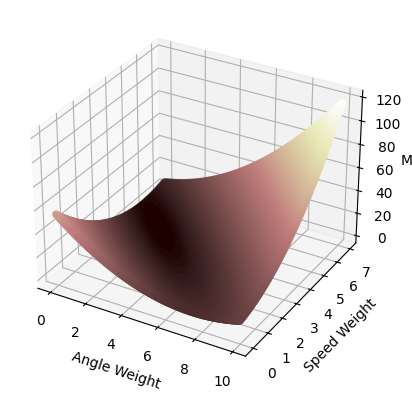

In [8]:
# MSE Plot
fig = plt.figure()
ax = plt.axes(projection='3d')
X, Y, Z = results['aw'], results['sw'], results['mse']
ax.scatter3D(X, Y, Z, c=Z, cmap='pink')
ax.set_xlabel('Angle Weight')
ax.set_ylabel('Speed Weight')
ax.set_zlabel('MSE')

plt.show()

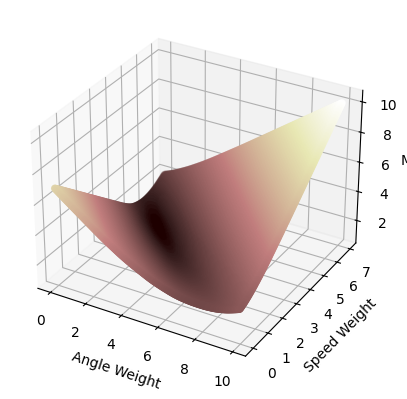

In [9]:
# MAE Plot
fig = plt.figure()
ax = plt.axes(projection='3d')
X, Y, Z = results['aw'], results['sw'], results['mae']
ax.scatter3D(X, Y, Z, c=Z, cmap='pink')
ax.set_xlabel('Angle Weight')
ax.set_ylabel('Speed Weight')
ax.set_zlabel('MAE')

plt.show()

In [10]:
# Best MSE
aw, sw, mse, mae = results.loc[results['mse'].idxmin()]
accsaber_ranked['algoComplexity'] = aw * accsaber_ranked['averageAngle'] + sw * accsaber_ranked['averageSpeed']
aw, sw, mse, mae

(1.9500000000000002, 4.25, 1.8031887776364606, 1.083686173728298)

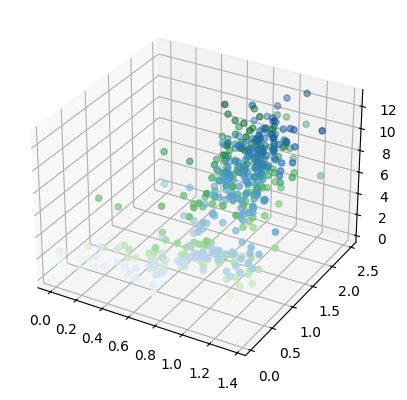

In [11]:
# Best MSE vs Accsaber
fig = plt.figure()
ax = plt.axes(projection='3d')
X, Y = accsaber_ranked['averageAngle'], accsaber_ranked['averageSpeed']
ax.scatter3D(X, Y, accsaber_ranked['complexity'], c=accsaber_ranked['complexity'], cmap='Greens')
ax.scatter3D(X, Y, accsaber_ranked['algoComplexity'], c=accsaber_ranked['algoComplexity'], cmap='Blues')

plt.show()

In [12]:
# Best MAE
aw, sw, mse, mae= results.loc[results['mae'].idxmin()]
accsaber_ranked['algoComplexity'] = aw * accsaber_ranked['averageAngle'] + sw * accsaber_ranked['averageSpeed']
aw, sw, mse, mae

(1.9000000000000001, 4.25, 1.8060688623915389, 1.0836757459203759)

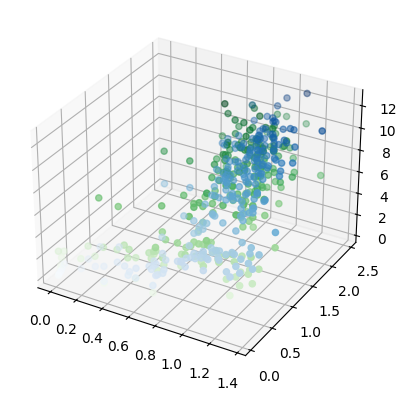

In [13]:
# Best MAE vs Accsaber
fig = plt.figure()
ax = plt.axes(projection='3d')
X, Y = accsaber_ranked['averageAngle'], accsaber_ranked['averageSpeed']
ax.scatter3D(X, Y, accsaber_ranked['complexity'], c=accsaber_ranked['complexity'], cmap='Greens')
ax.scatter3D(X, Y, accsaber_ranked['algoComplexity'], c=accsaber_ranked['algoComplexity'], cmap='Blues')

plt.show()

In [14]:
accsaber_ranked['algoComplexity'] = ANGLE_W * accsaber_ranked['averageAngle'] + SPEED_W * accsaber_ranked['averageSpeed']
mean_squared_error(accsaber_ranked['complexity'], accsaber_ranked['algoComplexity'])

2.128584022304755

In [15]:
accsaber_ranked['algoComplexity'] = accsaber_ranked['algoComplexity'].round(1)
accsaber_ranked[['songName', 'difficulty', 'complexity', 'algoComplexity']]

,songName,difficulty,complexity,algoComplexity
0,Crying for Rain,Easy,2.40,0.3
1,Easy Breezy,Expert,9.00,5.9
2,Nobody To Love,Hard,6.70,2.2
3,Midnight Moon,Easy,0.80,1.4
4,Level of Concern,Easy,3.90,3.3
...,...,...,...,...
229,Keep On Dancing,Easy,3.70,3.1
230,"Here, There and Everywhere",Easy,3.10,5.9
231,Last Man In The World,Expert,8.20,11.2
233,repeat until death,Easy,1.60,0.5
